In [1]:
# Cell 1: Authenticate & Download Dataset from Google Drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# ⬇️ Upload brain_tumor.zip to the root of Google Drive
fid = drive.ListFile({'q':"title='braintumor.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('braintumor.zip')
!unzip 'braintumor.zip'



Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [2]:
# Cell 2: Install and Import Libraries
!pip install -q tensorflow tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


In [3]:
# Cell 3: Define U-Net Segmentation Model

def unet_model(input_size=(128, 128, 3)):
    inputs = tf.keras.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b1)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(b1)
    u1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D((2, 2))(c3)
    u2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model


In [4]:
# Cell 4: Prepare Data for U-Net
input_root = '/content/Training'
os.makedirs('/content/brain_tumor_segmentation', exist_ok=True)
image_size = 128

X_data = []
Y_data = []

for class_name in os.listdir(input_root):
    class_path = os.path.join(input_root, class_name)
    if not os.path.isdir(class_path):
        continue
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        try:
            img = Image.open(img_path).convert('RGB').resize((image_size, image_size))
            mask = Image.open(img_path).convert('L').resize((image_size, image_size))  # Simulated mask
            X_data.append(np.array(img) / 255.0)
            Y_data.append(np.array(mask).reshape((image_size, image_size, 1)) / 255.0)
        except:
            continue

X_data = np.array(X_data)
Y_data = np.array(Y_data)


In [ ]:
# Cell 5: Split Dataset and Train U-Net
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ⚠️ Full training version (may take long)
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_val, Y_val))

# ✅ Quick test version
history = model.fit(X_train, Y_train, epochs=2, validation_data=(X_val, Y_val))


Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


143/143 ━━━━━━━━━━━━━━━━━━━━ 5431s 38s/step - accuracy: 0.1444 - loss: 0.4558 - val_accuracy: 0.1422 - val_loss: 0.3457
Epoch 2/2
132/143 ━━━━━━━━━━━━━━━━━━━━ 6:25 35s/step - accuracy: 0.1497 - loss: 0.3417

In [6]:
# Cell 6: Save Trained Segmentation Model
model.save('/content/unet_brain_segmentation.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(5, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


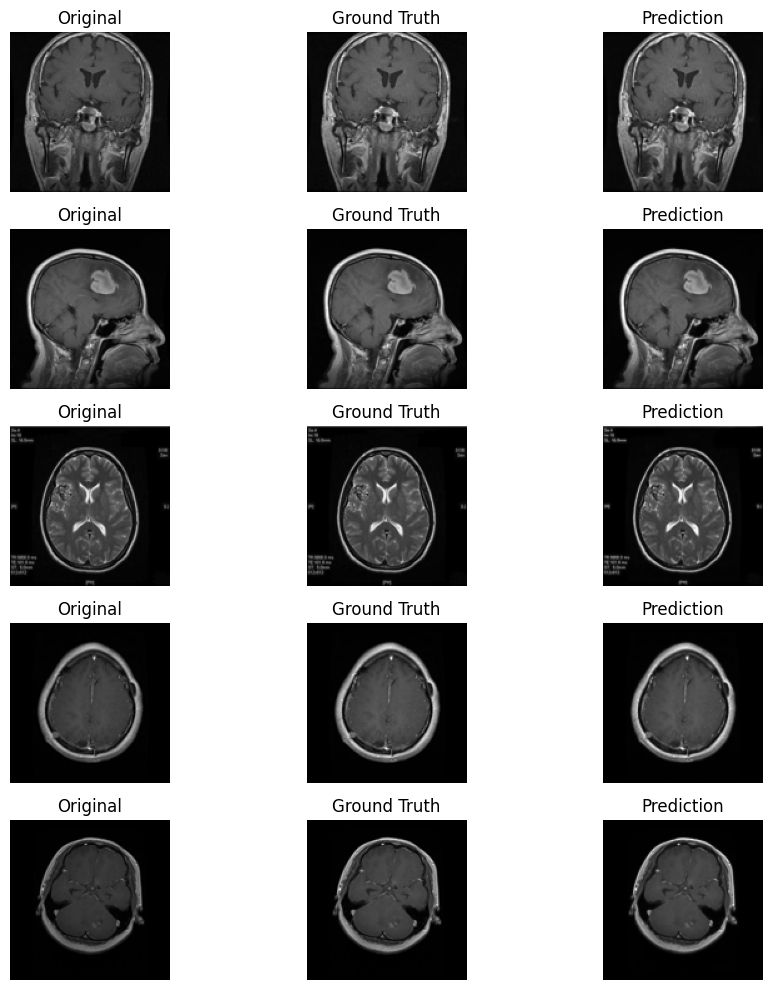

In [7]:
# Cell 7: Visualize Segmentation on Validation Set
preds = model.predict(X_val[:5])
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(5, 3, 3*i+1)
    plt.imshow(X_val[i])
    plt.title("Original")
    plt.axis('off')

    plt.subplot(5, 3, 3*i+2)
    plt.imshow(Y_val[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(5, 3, 3*i+3)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [10]:
# Cell 8: Prepare Segmented Data for Classification
from tensorflow.keras.preprocessing.image import ImageDataGenerator

segment_folder = '/content/Training'  # use original input_root
image_size_cls = 224
batch_size = 32

cls_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_cls_gen = cls_datagen.flow_from_directory(
    segment_folder,
    target_size=(image_size_cls, image_size_cls),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_cls_gen = cls_datagen.flow_from_directory(
    segment_folder,
    target_size=(image_size_cls, image_size_cls),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [11]:
# Cell 9: Build CNN Classifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = len(train_cls_gen.class_indices)
input_shape = (image_size_cls, image_size_cls, 3)

clf_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Cell 10: Compile and Train Classifier
clf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ⚠️ Full model training version (can be uncommented)
# clf_history = clf_model.fit(train_cls_gen, epochs=30, validation_data=val_cls_gen)

# ✅ Quick test run
clf_history = clf_model.fit(train_cls_gen, epochs=2, validation_data=val_cls_gen)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
143/143 ━━━━━━━━━━━━━━━━━━━━ 482s 3s/step - accuracy: 0.5826 - loss: 0.9635 - val_accuracy: 0.6836 - val_loss: 0.8295
Epoch 2/2
143/143 ━━━━━━━━━━━━━━━━━━━━ 464s 3s/step - accuracy: 0.8493 - loss: 0.4038 - val_accuracy: 0.7572 - val_loss: 0.7153


In [13]:
# Cell 11: Evaluate Classifier
from sklearn.metrics import classification_report
import numpy as np

loss, acc = clf_model.evaluate(val_cls_gen)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")

val_cls_gen.reset()
preds = clf_model.predict(val_cls_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_cls_gen.classes
class_labels = list(val_cls_gen.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))



36/36 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7738 - loss: 0.6303

✅ Validation Accuracy: 75.72%
36/36 ━━━━━━━━━━━━━━━━━━━━ 34s 939ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.83      0.89      0.86       264
  meningioma       0.58      0.52      0.55       267
     notumor       0.88      0.79      0.83       319
   pituitary       0.72      0.82      0.77       291

    accuracy                           0.76      1141
   macro avg       0.75      0.75      0.75      1141
weighted avg       0.76      0.76      0.75      1141



✅ Classifier model saved as braintumor_classification_model.h5


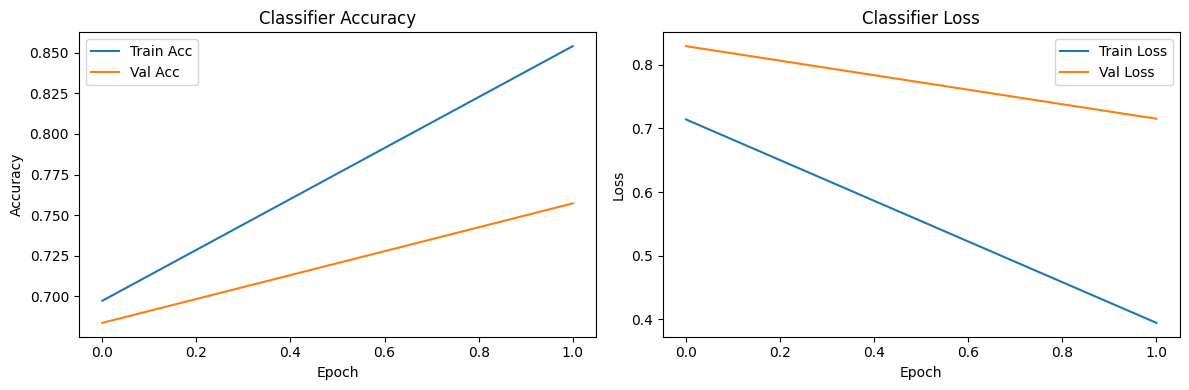

In [14]:
# Cell 12: Save Classification Model and Plot
clf_model.save('/content/braintumor_classification_model.h5')
print("✅ Classifier model saved as braintumor_classification_model.h5")

# Plot Accuracy and Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(clf_history.history['accuracy'], label='Train Acc')
plt.plot(clf_history.history['val_accuracy'], label='Val Acc')
plt.title("Classifier Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(clf_history.history['loss'], label='Train Loss')
plt.plot(clf_history.history['val_loss'], label='Val Loss')
plt.title("Classifier Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()
